# Лабораторная работа 4: Деревья. Случайный лес

## Часть 1: Основы построения решающие дерева

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [2]:
# Данные: 8 объектов класса k1, 2 объекта класса k2
n1, n2 = 8, 2
total = n1 + n2

# Вероятности каждого класса
p1 = n1 / total
p2 = n2 / total

# Расчет энтропии (с натуральным логарифмом)
# Учитываем случай p=0 (log(0) не считается)
entropy = 0
if p1 > 0:
    entropy -= p1 * np.log(p1)
if p2 > 0:
    entropy -= p2 * np.log(p2)

print(f"Энтропия: {entropy:.2f}")

Энтропия: 0.50


**Задание 1.2** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [3]:

# Функция для расчета индекса Джини
def gini_index(n_class1, n_class2):
    total = n_class1 + n_class2
    if total == 0:
        return 0
    p1 = n_class1 / total
    p2 = n_class2 / total
    return p1 * (1 - p1) + p2 * (1 - p2)

# Расчеты
H_Rm = gini_index(n1, n2)        # Исходная вершина
H_Rl = gini_index(8, 0)              # Левое поддерево (только k1)
H_Rr = gini_index(0, 2)              # Правое поддерево (только k2)

# Критерий информативности
total_Rm = n1 + n2
Q = H_Rm - (8/total_Rm)*H_Rl - (2/total_Rm)*H_Rr

print(f"Q = {Q:.2f}")

Q = 0.32


**Задание 1.3** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [4]:
# Значения целевой переменной в листовой вершине
y_values = np.array([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])

# Предсказание = среднее значение всех y в листе
prediction = np.mean(y_values)

print(f"Предсказание для всех объектов в листе: {prediction:.2f}")

Предсказание для всех объектов в листе: 40.60


## Часть 2: Решающие деревья

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [6]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [ ]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-

    pass

In [18]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:

    feature_vector = np.array(feature_vector).flatten()
    target_vector = np.array(target_vector).flatten()

    # Критерий ДО разделения
    if task == "classification":
        # Для классификации: индекс Джини
        counts = np.bincount(target_vector.astype(int))
        probs = counts / len(target_vector)
        initial_criterion = 1 - np.sum(probs ** 2)  # индекс Джини
    else:  # regression
        # Для регрессии: дисперсия
        initial_criterion = np.var(target_vector)

    unique_values = np.unique(feature_vector)

    if len(unique_values) <= 1:
        return np.array([]), np.array([]), -np.inf, -np.inf

    if feature_type == "real":
        sorted_unique = np.sort(unique_values)
        thresholds = (sorted_unique[:-1] + sorted_unique[1:]) / 2
    else:  # categorical
        thresholds = unique_values

    # Массивы для результатов
    ginis = np.zeros(len(thresholds))
    information_gains = np.zeros(len(thresholds))

    for i, thr in enumerate(thresholds):
        if feature_type == "real":
            left_mask = feature_vector <= thr
        else:  # categorical
            left_mask = feature_vector == thr

        right_mask = ~left_mask

        left_targets = target_vector[left_mask]
        right_targets = target_vector[right_mask]

        # Проверяем, чтобы в обеих частях были объекты
        if len(left_targets) == 0 or len(right_targets) == 0:
            ginis[i] = initial_criterion  # если пусто, то нет улучшения
            information_gains[i] = 0
            continue

        if task == "classification":
            # Джини для левой части
            left_counts = np.bincount(left_targets.astype(int))
            left_probs = left_counts / len(left_targets)
            gini_left = 1 - np.sum(left_probs ** 2)

            # Джини для правой части
            right_counts = np.bincount(right_targets.astype(int))
            right_probs = right_counts / len(right_targets)
            gini_right = 1 - np.sum(right_probs ** 2)

            # Взвешенное среднее Джини
            n_left = len(left_targets)
            n_right = len(right_targets)
            n_total = n_left + n_right
            weighted_criterion = (n_left * gini_left + n_right * gini_right) / n_total

        else:  # regression
            # Дисперсии
            var_left = np.var(left_targets)
            var_right = np.var(right_targets)

            # Взвешенное среднее дисперсий
            n_left = len(left_targets)
            n_right = len(right_targets)
            n_total = n_left + n_right
            weighted_criterion = (n_left * var_left + n_right * var_right) / n_total

        ginis[i] = weighted_criterion
        information_gains[i] = initial_criterion - weighted_criterion

    # Находим оптимальный порог (максимальный information gain)
    if len(information_gains) > 0:
        max_gain_idx = np.argmax(information_gains)
        threshold_best = thresholds[max_gain_idx]
        gini_best = information_gains[max_gain_idx]  # возвращаем information gain, а не взвешенный критерий
    else:
        threshold_best = -np.inf
        gini_best = -np.inf

    return thresholds, information_gains, threshold_best, gini_best

Эту функцию можно протестировать на датасете `California`.

In [8]:
from sklearn.datasets import fetch_california_housing

In [9]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [13]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

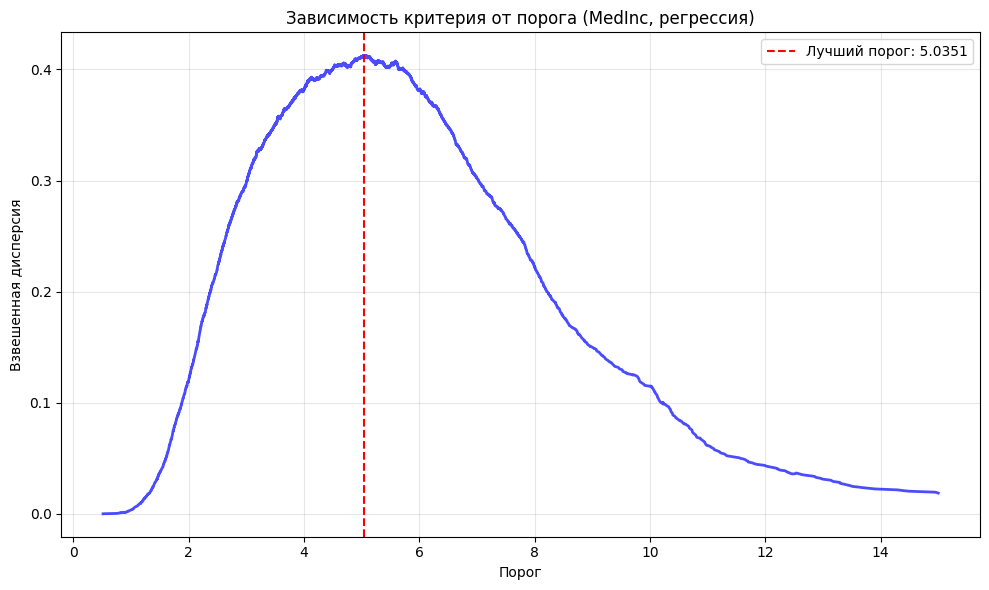

Лучший порог: 5.0351
Лучшая взвешенная дисперсия: 0.4128
Общая дисперсия до разделения: 1.3316


In [19]:
# Загружаем данные
from sklearn.datasets import fetch_california_housing
import pandas as pd
import matplotlib.pyplot as plt

data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]

# Тестируем
feature_vector = X['MedInc'].values
target_vector = y

thresholds, ginis, best_threshold, best_gini = find_best_split(
    feature_vector, target_vector, task="regression", feature_type="real"
)

# График
plt.figure(figsize=(10, 6))
plt.plot(thresholds, ginis, 'b-', alpha=0.7, linewidth=2)
plt.axvline(x=best_threshold, color='r', linestyle='--',
           label=f'Лучший порог: {best_threshold:.4f}')
plt.xlabel('Порог')
plt.ylabel('Взвешенная дисперсия')
plt.title('Зависимость критерия от порога (MedInc, регрессия)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Лучший порог: {best_threshold:.4f}")
print(f"Лучшая взвешенная дисперсия: {best_gini:.4f}")
print(f"Общая дисперсия до разделения: {np.var(y):.4f}")

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [20]:
best_feature = None
best_threshold = None
best_gain = -np.inf

for feature_name in X.columns:
    feature_vector = X[feature_name].values
    thresholds, ginis, threshold_best, gini_best = find_best_split(
        feature_vector, y, task="regression", feature_type="real"
    )

    if gini_best > best_gain:
        best_gain = gini_best
        best_threshold = threshold_best
        best_feature = feature_name

print(f"Лучший признак для первой вершины: {best_feature}")
print(f"Лучший порог: {best_threshold:.4f}")
print(f"Информационный выигрыш: {best_gain:.4f}")

print(f"\nПредикат первой вершины: {best_feature} <= {best_threshold:.4f}")

Лучший признак для первой вершины: MedInc
Лучший порог: 5.0351
Информационный выигрыш: 0.4128

Предикат первой вершины: MedInc <= 5.0351


**Задание 2.2** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [21]:
class DecisionTree:

    def __init__(
        self,
        feature_types: Union[List[str], np.ndarray],
        max_depth: int = None,
        min_samples_split: int = None,
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:

        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        self._tree = {}
        self._feature_types = feature_types
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task
        self._feature_importances = {}

    def _fit_node(self, sub_X: np.ndarray, sub_y: np.ndarray, node: dict, depth: int = 0) -> None:
        # Критерии останова
        if len(np.unique(sub_y)) == 1:  # все объекты одного класса
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        if self._max_depth is not None and depth >= self._max_depth:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        if self._min_samples_split is not None and len(sub_y) < self._min_samples_split:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        # Поиск лучшего разделения
        feature_best, threshold_best, gini_best, split = None, None, -np.inf, None

        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]

            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                feature_vector = sub_X[:, feature]

            # Ищем оптимальное разделение
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)

            if gini > gini_best:
                feature_best = feature
                gini_best = gini
                threshold_best = threshold

                # Создаем маску для левого поддерева
                if feature_type == "real":
                    split = feature_vector <= threshold
                elif feature_type == "categorical":
                    split = feature_vector == threshold

        # Если не нашли хорошего разделения
        if feature_best is None or (self._min_samples_leaf is not None and
                                    (np.sum(split) < self._min_samples_leaf or
                                     np.sum(~split) < self._min_samples_leaf)):
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        # Сохраняем информацию о разделении
        node["type"] = "nonterminal"
        node["feature_split"] = feature_best

        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best

        # Создаем детей и обучаем рекурсивно
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"], depth + 1)
        self._fit_node(sub_X[~split], sub_y[~split], node["right_child"], depth + 1)

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        # Если это лист - возвращаем предсказание
        if node["type"] == "terminal":
            return node["class"]

        # Иначе идем в нужное поддерево
        feature_idx = node["feature_split"]
        feature_type = self._feature_types[feature_idx]

        if feature_type == "real":
            # Для вещественных признаков
            if x[feature_idx] <= node["threshold"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        else:  # categorical
            # Для категориальных признаков
            if x[feature_idx] == node["category_split"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
        return np.array(predicted)

**Задание 2.3** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

Размерность данных: X.shape = (258, 5), y.shape = (258,)
Баланс классов: 0 - 107, 1 - 151

1. Графики 'порог — значение критерия Джини':


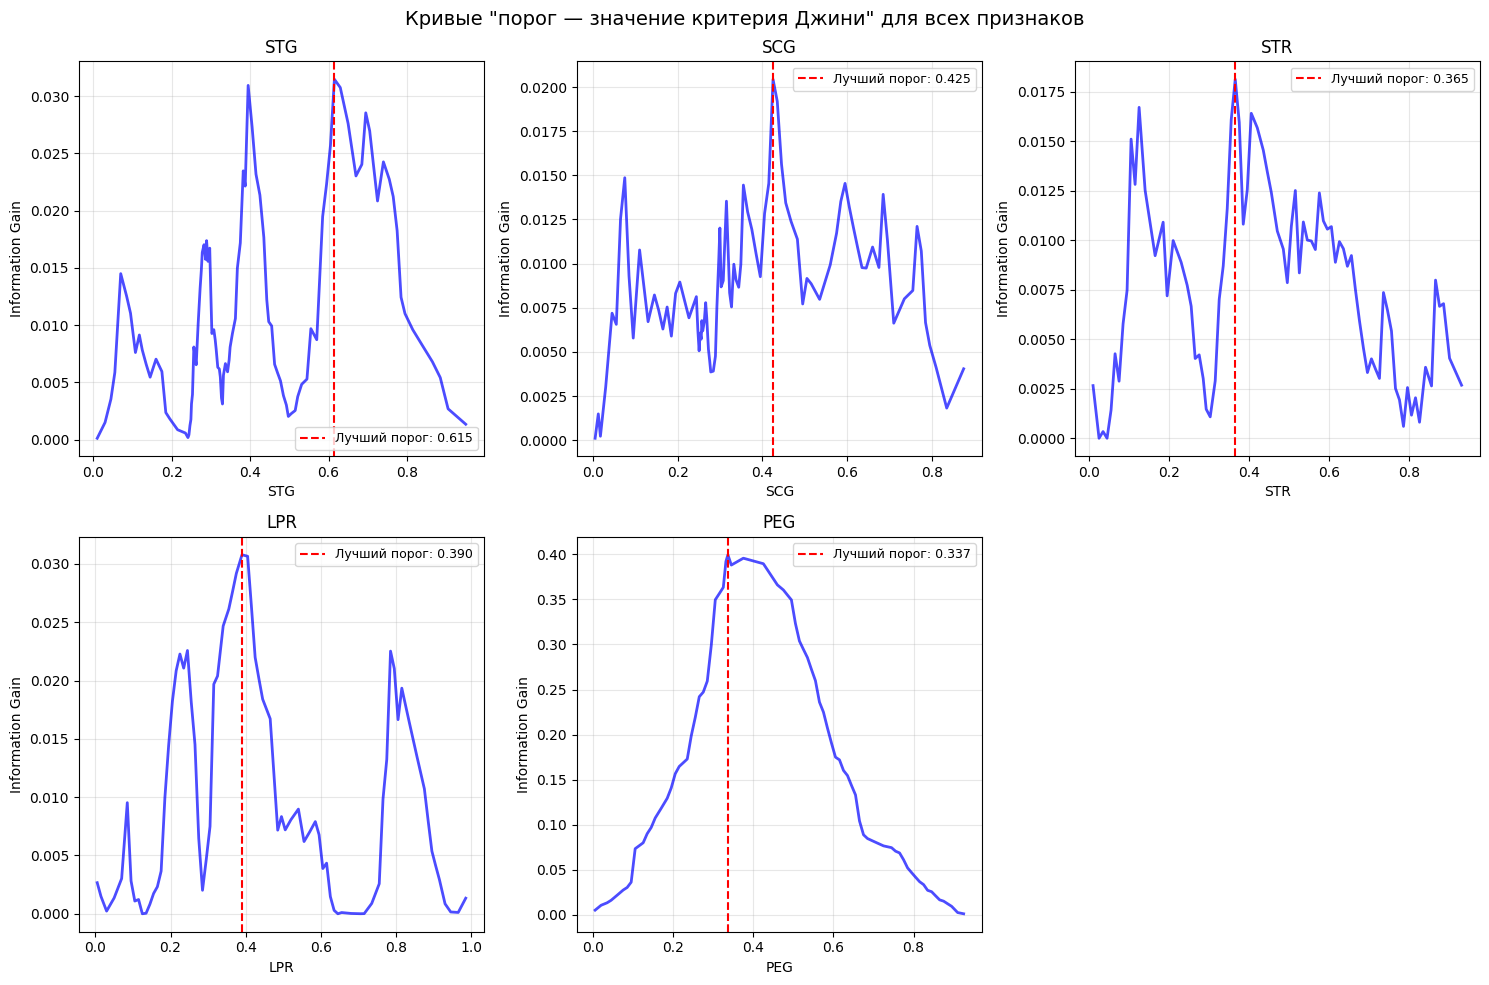


2. Диаграммы рассеяния 'значение признака — класс':


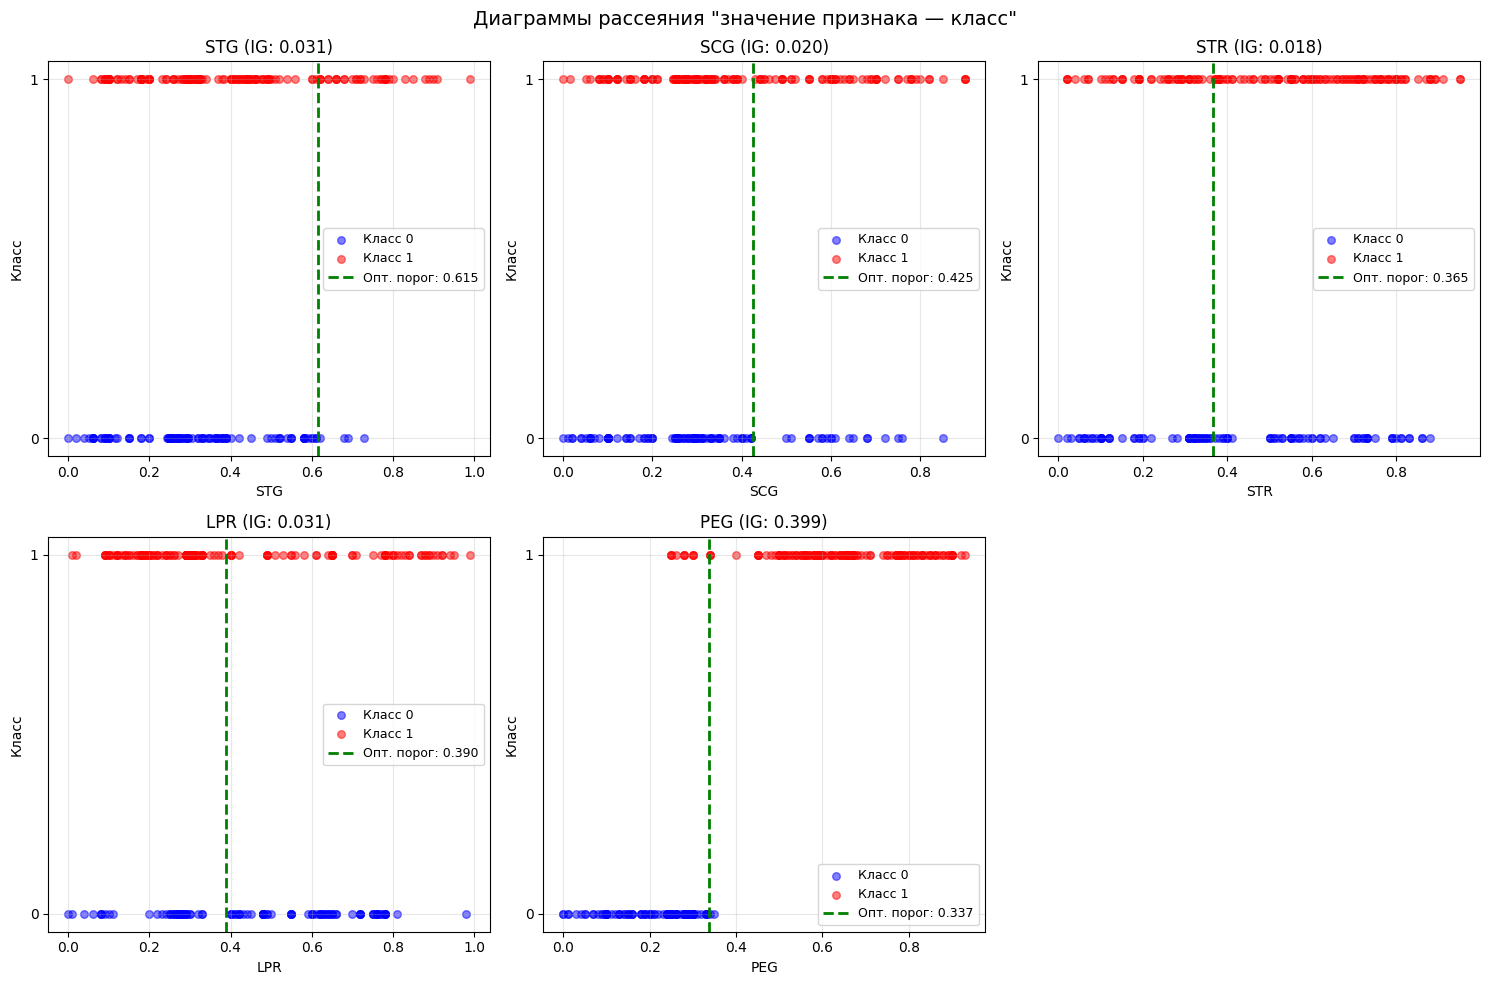


3. Сводная информация по всем признакам:
------------------------------------------------------------
Признак    | Лучший порог | Information Gain | Корреляция с классом
------------------------------------------------------------
STG        | 0.6150       | 0.0315          | 0.2144              
SCG        | 0.4250       | 0.0204          | 0.1983              
STR        | 0.3650       | 0.0181          | 0.1774              
LPR        | 0.3900       | 0.0308          | -0.1140             
PEG        | 0.3365       | 0.3994          | 0.8389              
------------------------------------------------------------

4. Поиск лучшего признака для первой вершины дерева:
Лучший признак: PEG
Лучший порог: 0.3365
Информационный выигрыш: 0.3994

Предикат для первой вершины: PEG <= 0.3365


In [23]:

students_df = pd.read_csv('students.csv')
X_students = students_df.iloc[:, 1:6].values  # Признаки (STG, SCG, STR, LPR, PEG)
y_students = students_df.iloc[:, 6].values    # Целевая переменная (UNS)

# Имена признаков
feature_names = ['STG', 'SCG', 'STR', 'LPR', 'PEG']

print(f"Размерность данных: X.shape = {X_students.shape}, y.shape = {y_students.shape}")
print(f"Баланс классов: 0 - {np.sum(y_students == 0)}, 1 - {np.sum(y_students == 1)}")

# 1. Графики "порог — значение критерия Джини" для всех признаков
print("\n1. Графики 'порог — значение критерия Джини':")
plt.figure(figsize=(15, 10))

for i, feature_name in enumerate(feature_names, 1):
    feature_vector = X_students[:, i-1]

    thresholds, info_gains, best_thr, best_gain = find_best_split(
        feature_vector, y_students, task="classification", feature_type="real"
    )

    plt.subplot(2, 3, i)
    plt.plot(thresholds, info_gains, 'b-', alpha=0.7, linewidth=2)
    plt.axvline(x=best_thr, color='r', linestyle='--',
               label=f'Лучший порог: {best_thr:.3f}')
    plt.xlabel(f'{feature_name}')
    plt.ylabel('Information Gain')
    plt.title(f'{feature_name}')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=9)

plt.suptitle('Кривые "порог — значение критерия Джини" для всех признаков', fontsize=14)
plt.tight_layout()
plt.show()

# 2. Диаграммы рассеяния "значение признака — класс"
print("\n2. Диаграммы рассеяния 'значение признака — класс':")
plt.figure(figsize=(15, 10))

for i, feature_name in enumerate(feature_names, 1):
    feature_vector = X_students[:, i-1]

    thresholds, info_gains, best_thr, best_gain = find_best_split(
        feature_vector, y_students, task="classification", feature_type="real"
    )

    plt.subplot(2, 3, i)

    # Разделяем данные по классам
    mask_class0 = y_students == 0
    mask_class1 = y_students == 1

    plt.scatter(feature_vector[mask_class0], y_students[mask_class0],
               alpha=0.5, s=30, label='Класс 0', color='blue')
    plt.scatter(feature_vector[mask_class1], y_students[mask_class1],
               alpha=0.5, s=30, label='Класс 1', color='red')

    plt.axvline(x=best_thr, color='green', linestyle='--', linewidth=2,
               label=f'Опт. порог: {best_thr:.3f}')

    plt.xlabel(f'{feature_name}')
    plt.ylabel('Класс')
    plt.yticks([0, 1], ['0', '1'])
    plt.title(f'{feature_name} (IG: {best_gain:.3f})')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=9)

plt.suptitle('Диаграммы рассеяния "значение признака — класс"', fontsize=14)
plt.tight_layout()
plt.show()

# 3. Сводная информация по всем признакам
print("\n3. Сводная информация по всем признакам:")
print("-" * 60)
print(f"{'Признак':<10} | {'Лучший порог':<12} | {'Information Gain':<15} | {'Корреляция с классом':<20}")
print("-" * 60)

for i, feature_name in enumerate(feature_names):
    feature_vector = X_students[:, i]

    thresholds, info_gains, best_thr, best_gain = find_best_split(
        feature_vector, y_students, task="classification", feature_type="real"
    )

    # Корреляция с целевой переменной
    correlation = np.corrcoef(feature_vector, y_students)[0, 1]

    print(f"{feature_name:<10} | {best_thr:<12.4f} | {best_gain:<15.4f} | {correlation:<20.4f}")

print("-" * 60)

# 4. Находим лучший признак для разделения
print("\n4. Поиск лучшего признака для первой вершины дерева:")
best_feature_idx = None
best_threshold_st = None
best_gain_st = -np.inf

for i, feature_name in enumerate(feature_names):
    feature_vector = X_students[:, i]

    thresholds, info_gains, thr_best, gain_best = find_best_split(
        feature_vector, y_students, task="classification", feature_type="real"
    )

    if gain_best > best_gain_st:
        best_gain_st = gain_best
        best_threshold_st = thr_best
        best_feature_idx = i

print(f"Лучший признак: {feature_names[best_feature_idx]}")
print(f"Лучший порог: {best_threshold_st:.4f}")
print(f"Информационный выигрыш: {best_gain_st:.4f}")
print(f"\nПредикат для первой вершины: {feature_names[best_feature_idx]} <= {best_threshold_st:.4f}")

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

In [ ]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————

**Задание 2.4** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom).

1. Скачайте таблицу `agaricus-lepiota.data` (находится в директории с ноутбуком),
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа.

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [ ]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [ ]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [ ]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Посмотрим на распределение целевой переменной

In [ ]:
data['Outcome'].hist()
plt.show()

**Задание 3.1** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [ ]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————

**Задание 3.2** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке.


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [ ]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————

**Задание 3.3** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [ ]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————

**Задание 3.4** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации.
3. Выберите ту пару значений, которая даёт наилучшее среднее качество.

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [ ]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————

**Задание 3.5** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

In [ ]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————

**Задание 3.6** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

In [ ]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————